In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#import maup
from zipfile import ZipFile
import numpy as np
import os
import shutil

# US House

## Final File - Load

In [2]:
pwd

'/Users/peterhorton/Documents/RDH/pdv/pdv-va/vest-va-2018'

In [3]:
final = gpd.read_file('./vest_va/va_2018_ushouse/va_2018_ushouse.shp')

In [118]:
print(final.shape)

(2463, 13)


# Election Results: US House

## Read in election results and append since files split accross districts

In [5]:
district = [str(1), str(2), str(3), str(4), str(5), str(6), str(7), str(8), str(9), str(10), str(11)]

In [6]:
#Party info from: https://ballotpedia.org/United_States_House_of_Representatives_elections_in_Virginia,_2018

candidate_to_party_dict = {'Robert Joseph Wittman': 'G18HORREP',
                           'Lavangelene Aereka Williams': 'G18HORDEM', 
                           'All Others': 'G18HORWRI',  
                           'Elaine Goodman Luria': 'G18HORDEM', 
                           'Scott William Taylor': 'G18HORREP',
                           'Robert Cortez Scott': 'G18HORDEM', 
                           'A. Donald McEachin': 'G18HORDEM', 
                           'Ryan Andrew McAdams': 'G18HORREP',
                           'Peter Joseph Wells': 'G18HORLIB', 
                           'Denver Lee Riggleman, III': 'G18HORREP',
                           'Leslie Corkill Cockburn': 'G18HORDEM', 
                           'Benjamin Lee Cline': 'G18HORREP', 
                           'Jennifer Lynn Lewis': 'G18HORDEM',
                           'Abigail Anne Davis Spanberger': 'G18HORDEM', 
                           'David A. Brat': 'G18HORREP',
                           'Joseph Buckler Walton': 'G18HORLIB', 
                           'Donald Sternoff Beyer, Jr.': 'G18HORDEM',
                           'Thomas Siyoung Oh': 'G18HORREP', 
                           'Howard Morgan Griffith': 'G18HORREP',
                           'Anthony Jude Flaccavento': 'G18HORDEM', 
                           'Jennifer Tosini Wexton': 'G18HORDEM',
                           'Barbara Jean Comstock': 'G18HORREP', 
                           'Gerald Edward Connolly': 'G18HORDEM',
                           'Jeffery Anthony Dove, Jr': 'G18HORREP', 
                           'Stevan Michael Porter': 'G18HORLIB'}


In [7]:
elections_by_district = []
for i in district:
    ref = './vest_va/us_house_results_by_district_2018/'
    file_name = ref + 'Virginia_Elections_Database__2018_U_S_House_General_Election_District_'+ i +'_including_precincts.csv'
    results = pd.read_csv(file_name)
    print(i, ' added to list')
    results['CON_DIST'] = i
    for col in results.columns:
        if col in candidate_to_party_dict.keys():
            col_new_name = candidate_to_party_dict.get(col)
            results = results.rename(columns = {col:col_new_name})
    elections_by_district.append(results)

1  added to list
2  added to list
3  added to list
4  added to list
5  added to list
6  added to list
7  added to list
8  added to list
9  added to list
10  added to list
11  added to list


In [8]:
df = pd.concat(elections_by_district, axis = 0)
df = df.reset_index()
df = df[df['County/City'] != 'TOTALS']
df['LOCALITY'] = df['County/City']
df = df.iloc[1:]
df = df.drop(['County/City', 'Ward', 'Total Votes Cast'], axis = 1)
df = df.fillna(value = 0)
df = df[(df['G18HORDEM'] != 'Democratic') & (df['G18HORREP'] != 'Republican') & (df['G18HORLIB'] != 'Libertarian')]
county_dict = pd.Series(final['COUNTYFP'].values, index = final['LOCALITY']).to_dict()
df['COUNTYFP'] = df['LOCALITY'].map(county_dict)

df['G18HORDEM'] = df['G18HORDEM'].map(lambda x: str(x).replace(',', ''))
df['G18HORREP'] = df['G18HORREP'].map(lambda x: str(x).replace(',', ''))
df['G18HORLIB'] = df['G18HORLIB'].map(lambda x: str(x).replace(',', ''))
df['G18HORWRI'] = df['G18HORWRI'].map(lambda x: str(x).replace(',', ''))

df['G18HORDEM'] = df['G18HORDEM'].astype(str).astype(float).astype(int)
df['G18HORREP'] = df['G18HORREP'].astype(str).astype(float).astype(int)
df['G18HORLIB'] = df['G18HORLIB'].astype(str).astype(float).astype(int)
df['G18HORWRI'] = df['G18HORWRI'].astype(str).astype(float).astype(int)

df['CON_DIST'] = df['CON_DIST'].astype(str)

## Check race totals and county-by-county totals

In [9]:
column_list = ['G18HORREP', 'G18HORDEM', 'G18HORWRI', 'G18HORLIB']

In [10]:
for val in column_list:
    vote_dif = df[val].sum()-final[val].sum()
    if (vote_dif == 0):
        print(val+": EQUAL")
    else:
        print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES")

G18HORREP: EQUAL
G18HORDEM: EQUAL
G18HORWRI: EQUAL
G18HORLIB: EQUAL


In [11]:
print("Counties with differences printed below:")
diff_counties=[]
for i in column_list:
    diff = df.groupby(["COUNTYFP"]).sum()[i]-final.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:

All other races in all counties are equal


## Re allocate absentee votes

### Account for CD differences by county

In [12]:
cd_abs_prov_prec = df[((df['Pct'].map(lambda x: 'Absentee' in str(x))) &(df['Pct'].map(lambda x: 'CD' in str(x)))) | ((df['Pct'].map(lambda x: 'Provisional' in str(x))) & (df['Pct'].map(lambda x: 'CD' in str(x))))]

df['countyfp_cd'] = df['COUNTYFP'] + '-' + df['CON_DIST']

In [13]:
absentee_and_prov = df[(df['Pct'].map(lambda x: 'Absentee' in str(x))) | (df['Pct'].map(lambda x: 'Provisional' in str(x)))]
groupby_absentee_and_prov_tot = absentee_and_prov.groupby(['countyfp_cd']).sum()

In [14]:
groupby_county_df_tot = df.groupby(['countyfp_cd']).sum()
df_no_absent_or_provisional = df[(df['Pct'].map(lambda x: 'Absentee' not in str(x))) & (df['Pct'].map(lambda x: 'Provisional' not in str(x)))
                                & (df['LOCALITY'] != 'TOTALS')]
groupby_county_tot_no_absentee = df_no_absent_or_provisional.groupby('countyfp_cd').sum()

column_list = ['G18HORREP', 'G18HORDEM', 'G18HORWRI', 'G18HORLIB']

In [15]:
df_with_absentee_reallocated = df_no_absent_or_provisional.copy()
groupby_absentee_and_prov_tot.reset_index(inplace=True,drop=False)
groupby_county_tot_no_absentee.reset_index(inplace=True,drop=False)

to_dole_out_totals = groupby_absentee_and_prov_tot.copy()
precinct_specific_totals = groupby_county_tot_no_absentee.copy()

In [16]:
## PH CODE for vote allocation


#countyfp_cd
#df_no_absent_or_provisional
column_list = ['G18HORREP', 'G18HORDEM', 'G18HORWRI', 'G18HORLIB']

#Create some new columns for each of these races to deal with the allocation
for race in column_list:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    df_with_absentee_reallocated.loc[:,add_var]=0.0
    df_with_absentee_reallocated.loc[:,rem_var]=0.0
    df_with_absentee_reallocated.loc[:,floor_var]=0.0

#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
for index, row in df_no_absent_or_provisional.iterrows():
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["countyfp_cd"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["countyfp_cd"]==county_id][race]
        #Get one of the numerators, how many districtwide votes to allocate
        numer = to_dole_out_totals.loc[to_dole_out_totals["countyfp_cd"]==county_id][race]
        #Get the vote totals for this race in this precinct
        val = df_with_absentee_reallocated.at[index,race]
        #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
        if ((float(denom)==0)):
            vote_share = 0
        else:
            vote_share = (float(val)/float(denom))*float(numer)
        df_with_absentee_reallocated.at[index,add_var] = vote_share
        #Take the decimal remainder of the allocation
        df_with_absentee_reallocated.at[index,rem_var] = vote_share%1
        #Take the floor of the allocation
        df_with_absentee_reallocated.at[index,floor_var] = np.floor(vote_share)

#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(df_with_absentee_reallocated.groupby(["countyfp_cd"]).sum())

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["countyfp_cd"].unique()) 

#Iterate over the district
for county in county_list:
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["countyfp_cd"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in df_with_absentee_reallocated.loc[df_with_absentee_reallocated["countyfp_cd"]==county][rem_var].nlargest(to_go).index:
            df_with_absentee_reallocated.at[index,add_var] = np.ceil(df_with_absentee_reallocated.at[index,add_var])

#Iterate over every race again
for race in column_list:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    df_with_absentee_reallocated.loc[:,add_var]=np.floor(df_with_absentee_reallocated.loc[:,add_var])
    df_with_absentee_reallocated.loc[:,race]+=df_with_absentee_reallocated.loc[:,add_var]

In [17]:
for val in column_list:
    vote_dif = df_with_absentee_reallocated[val].sum()-final[val].sum()
    if (vote_dif == 0):
        print(val+": EQUAL")
    else:
        print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES")

G18HORREP: EQUAL
G18HORDEM: EQUAL
G18HORWRI: EQUAL
G18HORLIB: EQUAL


In [18]:
print("Counties with differences printed below:")
diff_counties=[]
for i in column_list:
    diff = df_with_absentee_reallocated.groupby(["COUNTYFP"]).sum()[i]-final.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:

All other races in all counties are equal


## Creating unique id to enable merge

In [19]:
final['unique_id'] = final['COUNTYFP'] + final['VTDST'].str.slice(start = 3)

In [20]:
final['unique_id'].nunique()

2441

In [21]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated.Pct.str.slice(stop = 3)

In [22]:
def vtdst_changer(vtdst):
    if (vtdst[1:3] == ' -'):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[1:3] == '- '):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[-1:] == ' '):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    elif (vtdst[-1:] == '-'):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    else:
        return vtdst

In [23]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated['vtdst'].apply(vtdst_changer)
df_with_absentee_reallocated[df_with_absentee_reallocated['vtdst'].str.slice(start = -1) == '-'] #check that above worked

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORDEM_add,G18HORDEM_rem,G18HORDEM_floor,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst


In [24]:
df_with_absentee_reallocated['unique_id'] = df_with_absentee_reallocated['COUNTYFP'] + df_with_absentee_reallocated['vtdst']

In [25]:
df_id_count = df_with_absentee_reallocated['unique_id'].value_counts()
df_double_list = df_id_count[df_id_count > 1].index
final_id_count = final.unique_id.value_counts()
final_double_list = final_id_count[final_id_count > 1].index
print(set(df_double_list) - set(final_double_list))
print(set(final_double_list) - set(df_double_list))

set()
set()


**USE CON_DIST to account for the rest of the unique ids**

In [26]:
(final['unique_id'] + final['CON_DIST']).nunique()

2463

In [27]:
(df_with_absentee_reallocated['unique_id'] + df_with_absentee_reallocated['CON_DIST']).nunique()

2462

In [28]:
df_with_absentee_reallocated['unique_id_1'] = df_with_absentee_reallocated['unique_id'] + '-' + df_with_absentee_reallocated['CON_DIST']
final['unique_id_1'] = final['unique_id'] + '-' + final['CON_DIST']

In [29]:
print(set(final['unique_id_1']) - set(df_with_absentee_reallocated['unique_id_1']))
print(set(df_with_absentee_reallocated['unique_id_1']) - set(final['unique_id_1']))

{'059700-11', '003499-5', '003599-5'}
{'003407-5', '003507-5'}


In [30]:
d = {'003407-5':'003499-5', '003507-5': '003599-5'}
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(d.keys()), 'unique_id_1'] = df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(d.keys()), 'unique_id_1'].map(d)

In [31]:
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'] == '003407']

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORDEM_floor,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst,unique_id,unique_id_1
976,19,407 - Biscuit Run,321.0,1065.0,2.0,5,0.0,Albemarle County,003,003-5,...,123.0,0.0,0.207547,0.0,0.0,0.0,0.0,407,003407,003499-5


In [32]:
final.loc[final['unique_id'] == '003499']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1
29,003,Albemarle County,000499,Biscuit Run,5,1065,321,0,2,"POLYGON Z ((-78.53848 37.98576 0.00000, -78.53...",003499,003499-5


In [33]:
print(set(final['unique_id_1']) - set(df_with_absentee_reallocated['unique_id_1']))
print(set(df_with_absentee_reallocated['unique_id_1']) - set(final['unique_id_1']))

{'059700-11'}
set()


In [34]:
assert final.unique_id_1.nunique() == final.shape[0]

# Shapefile

In [35]:
pwd

'/Users/peterhorton/Documents/RDH/pdv/pdv-va/vest-va-2018'

In [36]:
#path = ('./vest_va/census_shps_by_county_all_unzip/')
#os.chdir(path)
county_fips = []
for directory in os.listdir('./vest_va/census_shps_by_county_all_unzip/'):
    if not directory[0] == '.':
        county_fips.append(directory[-5:])

In [37]:
proj = final.crs

In [38]:
#path = ('./vest_va/')
#os.chdir(path)
county_vtds = []

for i in county_fips: #i dont have fips_codes file
    ref = './vest_va/census_shps_by_county_all_unzip/partnership_shapefiles_19v2_'
    vtd_ref = ref + i + '/PVS_19_v2_vtd_' + i + '.shp' 
    vtd_shp = gpd.read_file(vtd_ref)
    print(i, ' added to list')
    county_vtds.append(vtd_shp)

51580  added to list
51117  added to list
51121  added to list
51119  added to list
51770  added to list
51181  added to list
51175  added to list
51143  added to list
51520  added to list
51127  added to list
51740  added to list
51111  added to list
51145  added to list
51510  added to list
51187  added to list
51173  added to list
51001  added to list
51650  added to list
51037  added to list
51063  added to list
51097  added to list
51099  added to list
51009  added to list
51660  added to list
51036  added to list
51031  added to list
51007  added to list
51053  added to list
51065  added to list
51091  added to list
51047  added to list
51071  added to list
51085  added to list
51049  added to list
51620  added to list
51680  added to list
51025  added to list
51013  added to list
51810  added to list
51077  added to list
51083  added to list
51079  added to list
51610  added to list
51041  added to list
51015  added to list
51023  added to list
51820  added to list
51169  added 

In [39]:
global shp
shp = gpd.GeoDataFrame(pd.concat(county_vtds, axis = 0) , crs = proj) 

<AxesSubplot:>

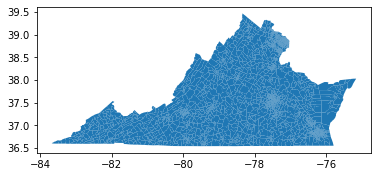

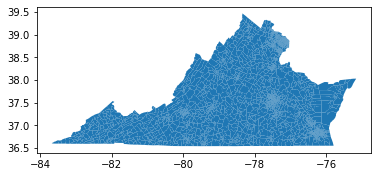

In [40]:
shp.plot()
final.plot()

In [41]:
shp.shape

(2462, 16)

In [42]:
final.shape

(2463, 12)

In [43]:
shp['unique_id'] = shp['COUNTYFP'] + shp['VTDST'].str.slice(start = 3)

In [44]:
shp['unique_id_1'] = shp['unique_id']

In [45]:
d = {'003407':'003499', '003507': '003599'}
shp.loc[shp['unique_id'].isin(d.keys()), 'unique_id_1']=shp.loc[shp['unique_id'].isin(d.keys()), 'unique_id_1'].map(d)
shp.loc[shp['unique_id'].isin(d.keys())]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
28,51,003,000407,Biscuit Run,A,00,None,None,None,None,Biscuit Run,90,N,None,G5240,"POLYGON Z ((-78.53848 37.98576 0.00000, -78.53...",003407,003499
29,51,003,000507,Pantops,A,00,None,None,None,None,Pantops,90,N,None,G5240,"POLYGON Z ((-78.45505 38.04404 0.00000, -78.45...",003507,003599


In [46]:
len(set(final.unique_id) - set(shp.unique_id_1))

8

In [47]:
len(set(shp['unique_id_1']) - set(final.unique_id))

28

In [48]:
set(shp.unique_id_1)  - set(final.unique_id)

{'041113',
 '041216',
 '041314',
 '041319',
 '041412',
 '077011',
 '077012',
 '095041',
 '095042',
 '121032',
 '153061',
 '153062',
 '153114',
 '153315',
 '161401',
 '191021',
 '191022',
 '510112',
 '510309',
 '520041',
 '520042',
 '550064',
 '550065',
 '685031',
 '685032',
 '750004',
 '760215',
 '760415'}

In [49]:
final_uniqe_not_in_shp = list(set(final.unique_id) - set(shp.unique_id_1))

In [50]:
final[final['unique_id'].isin(final_uniqe_not_in_shp)]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1
1304,153,Prince William County,000106,Westgate,1,962,296,0,1,"POLYGON Z ((-77.53727 38.77568 0.00000, -77.53...",153106,153106-1
1731,550,Chesapeake City,000040,River Birch,3,1389,0,0,186,"POLYGON Z ((-76.23347 36.78440 0.00000, -76.23...",550040,550040-3
1733,550,Chesapeake City,000047,Green Sea,4,277,549,15,1,"POLYGON Z ((-76.28603 36.69691 0.00000, -76.28...",550047,550047-4
2236,077,Grayson County,000401,Fries,9,107,221,0,0,"MULTIPOLYGON Z (((-81.08851 36.76885 0.00000, ...",077401,077401-9
2240,095,James City County,000104,Berkeley D,2,444,369,0,1,"MULTIPOLYGON Z (((-76.75418 37.24672 0.00000, ...",095104,095104-2
2260,685,Manassas Park City,000003,Precinct Three,10,939,513,0,0,"MULTIPOLYGON Z (((-77.45337 38.76934 0.00000, ...",685003,685003-10
2261,191,Washington County,000702,WALLACE,9,143,449,0,0,"MULTIPOLYGON Z (((-82.14454 36.66976 0.00000, ...",191702,191702-9
2341,520,Bristol City,000004,Fourth Ward,9,603,1618,0,3,"MULTIPOLYGON Z (((-82.15659 36.63121 0.00000, ...",520004,520004-9


In [51]:
shp_unique_id_missing = list(set(shp.unique_id_1) - set(final.unique_id))
#plot fries part 1 and 2, should come out the same

In [52]:
shp[shp['unique_id'].isin(shp_unique_id_missing)]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
23,51,121,002032,B-3 part 2,A,00,None,None,None,None,B-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.44921 37.16344 0.00000, -80.44...",121032,121032
24,51,121,004032,D-3 part 2,A,00,None,None,None,None,D-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.51937 37.13193 0.00000, -80.51...",121032,121032
3,51,520,000041,Fourth Ward Part 1 Voting District,P,V2,None,None,None,None,Fourth Ward Part 1,90,S,None,G5240,"POLYGON Z ((-82.16028 36.62071 0.00000, -82.15...",520041,520041
4,51,520,000042,Fourth Ward Part 2 Voting District,P,V2,None,None,None,None,Fourth Ward Part 2,90,S,None,G5240,"POLYGON Z ((-82.12869 36.64952 0.00000, -82.12...",520042,520042
20,51,510,000112,Alex Renew Voting District,A,V2,None,None,None,None,Alex Renew,90,N,None,G5240,"POLYGON Z ((-77.07746 38.80083 0.00000, -77.07...",510112,510112
21,51,510,000309,Olympus Condo Voting District,A,V2,None,None,None,None,Olympus Condo,90,N,None,G5240,"POLYGON Z ((-77.14368 38.81340 0.00000, -77.14...",510309,510309
14,51,077,004011,Fries Part 1 Voting District,P,V2,None,None,None,None,Fries Part 1,90,S,None,G5240,"POLYGON Z ((-81.08851 36.76885 0.00000, -81.08...",077011,077011
15,51,077,004012,Fries Part 2 Voting District,P,V2,None,None,None,None,Fries Part 2,90,S,None,G5240,"POLYGON Z ((-81.01449 36.70041 0.00000, -81.01...",077012,077012
13,51,041,000113,Iron Bridge North Voting District,A,V2,None,None,None,None,Iron Bridge North,90,N,None,G5240,"POLYGON Z ((-77.50202 37.37361 0.00000, -77.50...",041113,041113
14,51,041,000216,Ridgedale Voting District,A,V2,None,None,None,None,Ridgedale,90,N,None,G5240,"POLYGON Z ((-77.53608 37.41786 0.00000, -77.53...",041216,041216


In [53]:
set(final.unique_id) - set(shp.unique_id_1) 

{'077401',
 '095104',
 '153106',
 '191702',
 '520004',
 '550040',
 '550047',
 '685003'}

In [54]:
final.unique_id.nunique()

2441

In [55]:
df_with_absentee_reallocated.unique_id.nunique()

2440

In [56]:
(final.COUNTYFP + final.VTDST.str.slice(start = 3)).nunique()

2441

In [57]:
final.head()

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1
0,001,Accomack County,000101,Chincoteague,2,533,1039,0,1,"POLYGON Z ((-75.42507 37.89957 0.00000, -75.42...",001101,001101-2
1,001,Accomack County,000201,Atlantic,2,171,482,0,2,"POLYGON Z ((-75.59978 37.87664 0.00000, -75.59...",001201,001201-2
2,001,Accomack County,000202,Greenbackville,2,307,595,0,1,"POLYGON Z ((-75.49919 37.93416 0.00000, -75.49...",001202,001202-2
3,001,Accomack County,000301,New Church,2,583,490,0,0,"POLYGON Z ((-75.64987 37.92702 0.00000, -75.64...",001301,001301-2
4,001,Accomack County,000401,Bloxom,2,118,286,0,0,"POLYGON Z ((-75.71556 37.87513 0.00000, -75.71...",001401,001401-2


In [58]:
df_with_absentee_reallocated.head()

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORDEM_floor,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst,unique_id,unique_id_1
1,1,101 - Bowling Green,725.0,357.0,0.0,1,0.0,Caroline County,033,033-1,...,26.0,0.0,0.0,0.0,0.0,0.0,0.0,101,033101,033101-1
2,2,102 - Sparta,518.0,305.0,1.0,1,0.0,Caroline County,033,033-1,...,22.0,0.0,0.2,0.0,0.0,0.0,0.0,102,033102,033102-1
3,3,201 - North Madison,428.0,506.0,0.0,1,0.0,Caroline County,033,033-1,...,37.0,0.0,0.0,0.0,0.0,0.0,0.0,201,033201,033201-1
4,4,202 - South Madison,640.0,520.0,0.0,1,0.0,Caroline County,033,033-1,...,38.0,0.0,0.0,0.0,0.0,0.0,0.0,202,033202,033202-1
5,5,301 - Port Royal,281.0,196.0,0.0,1,0.0,Caroline County,033,033-1,...,14.0,0.0,0.0,0.0,0.0,0.0,0.0,301,033301,033301-1


In [59]:
shp.head()

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
0,51,580,000101,Precinct 1-1,A,00,None,None,None,None,Precinct 1-1,90,N,None,G5240,"POLYGON Z ((-80.00136 37.78983 0.00000, -80.00...",580101,580101
1,51,580,000201,Precinct 2-1,A,00,None,None,None,None,Precinct 2-1,90,N,None,G5240,"POLYGON Z ((-79.99129 37.79115 0.00000, -79.99...",580201,580201
2,51,580,000301,Precinct 3-1,A,00,None,None,None,None,Precinct 3-1,90,N,None,G5240,"POLYGON Z ((-79.99661 37.78701 0.00000, -79.99...",580301,580301
3,51,580,000401,Precinct 4-1,A,00,None,None,None,None,Precinct 4-1,90,N,None,G5240,"POLYGON Z ((-79.99797 37.78069 0.00000, -79.99...",580401,580401
4,51,580,000501,Precinct 5-1,A,00,None,None,None,None,Precinct 5-1,90,N,None,G5240,"POLYGON Z ((-80.00899 37.76259 0.00000, -80.00...",580501,580501


### Refining shp unique id match to election results

In [60]:
shp_id_list = list(set(shp['unique_id']) - set(df_with_absentee_reallocated['unique_id']))
df_id_list = list(set(df_with_absentee_reallocated['unique_id']) - set(shp['unique_id']))

In [61]:
print(shp.shape[0])
print(len(shp_id_list))
print(df_with_absentee_reallocated.shape[0])
len(df_id_list)

2462
29
2462


8

In [62]:
shp['COUNTYFP'][shp['unique_id'].isin(shp_id_list)].value_counts()

041    5
153    4
510    2
095    2
077    2
520    2
760    2
550    2
191    2
121    2
685    2
059    1
750    1
161    1
Name: COUNTYFP, dtype: int64

**See below, hand check all by Name/Precinct/NAMELSAD, then check via plot**

In [63]:
shp[shp['unique_id'].isin(shp_id_list)]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
23,51,121,002032,B-3 part 2,A,00,None,None,None,None,B-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.44921 37.16344 0.00000, -80.44...",121032,121032
24,51,121,004032,D-3 part 2,A,00,None,None,None,None,D-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.51937 37.13193 0.00000, -80.51...",121032,121032
3,51,520,000041,Fourth Ward Part 1 Voting District,P,V2,None,None,None,None,Fourth Ward Part 1,90,S,None,G5240,"POLYGON Z ((-82.16028 36.62071 0.00000, -82.15...",520041,520041
4,51,520,000042,Fourth Ward Part 2 Voting District,P,V2,None,None,None,None,Fourth Ward Part 2,90,S,None,G5240,"POLYGON Z ((-82.12869 36.64952 0.00000, -82.12...",520042,520042
20,51,510,000112,Alex Renew Voting District,A,V2,None,None,None,None,Alex Renew,90,N,None,G5240,"POLYGON Z ((-77.07746 38.80083 0.00000, -77.07...",510112,510112
21,51,510,000309,Olympus Condo Voting District,A,V2,None,None,None,None,Olympus Condo,90,N,None,G5240,"POLYGON Z ((-77.14368 38.81340 0.00000, -77.14...",510309,510309
14,51,077,004011,Fries Part 1 Voting District,P,V2,None,None,None,None,Fries Part 1,90,S,None,G5240,"POLYGON Z ((-81.08851 36.76885 0.00000, -81.08...",077011,077011
15,51,077,004012,Fries Part 2 Voting District,P,V2,None,None,None,None,Fries Part 2,90,S,None,G5240,"POLYGON Z ((-81.01449 36.70041 0.00000, -81.01...",077012,077012
13,51,041,000113,Iron Bridge North Voting District,A,V2,None,None,None,None,Iron Bridge North,90,N,None,G5240,"POLYGON Z ((-77.50202 37.37361 0.00000, -77.50...",041113,041113
14,51,041,000216,Ridgedale Voting District,A,V2,None,None,None,None,Ridgedale,90,N,None,G5240,"POLYGON Z ((-77.53608 37.41786 0.00000, -77.53...",041216,041216


In [64]:
df_with_absentee_reallocated[(df_with_absentee_reallocated['COUNTYFP'] == '121') & (df_with_absentee_reallocated['Pct'].str.contains('D'))]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORDEM_floor,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst,unique_id,unique_id_1
2187,194,401 - Precinct D-1,566.0,402.0,0.0,9,0.0,Montgomery County,121,121-9,...,30.0,0.0,0.000000,0.0,0.0,0.0,0.0,401,121401,121401-9
2188,195,402 - Precinct D-2,1055.0,431.0,0.0,9,0.0,Montgomery County,121,121-9,...,33.0,0.0,0.000000,0.0,0.0,0.0,0.0,402,121402,121402-9
2189,196,403 - Precinct D-3,794.0,353.0,0.0,9,0.0,Montgomery County,121,121-9,...,27.0,0.0,0.000000,0.0,0.0,0.0,0.0,403,121403,121403-9
2190,197,404 - Precinct D-4,464.0,183.0,0.0,9,0.0,Montgomery County,121,121-9,...,14.0,0.0,0.000000,0.0,0.0,0.0,0.0,404,121404,121404-9
2191,198,405 - Precinct D-5,933.0,760.0,2.0,9,0.0,Montgomery County,121,121-9,...,58.0,0.0,0.058824,0.0,0.0,0.0,0.0,405,121405,121405-9


In [65]:
shp[(shp['unique_id'].str.slice(stop = 3) == '550') & (shp['NAME'].str.contains('Green'))] #041 042

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
11,51,550,000007,Greenbrier Voting District,A,V2,None,None,None,None,Greenbrier,90,N,None,G5240,"POLYGON Z ((-76.21963 36.75324 0.00000, -76.21...",550007,550007
49,51,550,000056,Green Tree Voting District,A,V2,None,None,None,None,Green Tree,90,N,None,G5240,"POLYGON Z ((-76.25327 36.74277 0.00000, -76.25...",550056,550056


In [66]:
final[(final['COUNTYFP'] == '550') & (final['PRECINCT'].str.contains('Green'))] #760215 

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1
1705,550,Chesapeake City,000007,Greenbrier,4,786,1070,18,2,"POLYGON Z ((-76.22488 36.75309 0.00000, -76.22...",550007,550007-4
1733,550,Chesapeake City,000047,Green Sea,4,277,549,15,1,"POLYGON Z ((-76.28603 36.69691 0.00000, -76.28...",550047,550047-4
1739,550,Chesapeake City,000056,Green Tree,3,885,0,0,146,"POLYGON Z ((-76.24810 36.75531 0.00000, -76.24...",550056,550056-3


In [67]:
shp.unique_id.nunique()

2461

In [68]:
shp.shape[0]

2462

In [69]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'].isin(df_id_list)]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORDEM_floor,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst,unique_id,unique_id_1
169,169,106 - Westgate,296.0,961.0,1.0,1,0.0,Prince William County,153,153-1,...,142.0,0.0,0.170940,0.0,0.0,0.000000,0.0,106,153106,153106-1
295,29,104- Berkeley D,368.0,444.0,1.0,2,0.0,James City County,095,095-2,...,64.0,0.0,0.052632,0.0,0.0,0.000000,0.0,104,095104,095104-2
482,25,40 - River Birch,0.0,1388.0,186.0,3,0.0,Chesapeake City,550,550-3,...,83.0,10.0,0.993048,9.0,0.0,0.000000,0.0,040,550040,550040-3
702,26,47 - Green Sea,550.0,277.0,1.0,4,15.0,Chesapeake City,550,550-4,...,27.0,0.0,0.060000,0.0,1.0,0.817664,0.0,047,550047,550047-4
2020,27,4 - Fourth Ward,1618.0,602.0,3.0,9,0.0,Bristol City,520,520-9,...,56.0,0.0,0.000000,0.0,0.0,0.000000,0.0,004,520004,520004-9
2124,131,401 - Fries,221.0,107.0,0.0,9,0.0,Grayson County,077,077-9,...,8.0,0.0,0.000000,0.0,0.0,0.000000,0.0,401,077401,077401-9
2353,360,702 - Wallace,449.0,143.0,0.0,9,0.0,Washington County,191,191-9,...,15.0,0.0,0.000000,0.0,0.0,0.000000,0.0,702,191702,191702-9
2579,194,3 - Precinct Three,513.0,939.0,0.0,10,0.0,Manassas Park City,685,685-10,...,122.0,0.0,0.000000,0.0,0.0,0.000000,0.0,003,685003,685003-10


In [70]:
len(df_id_list)

8

In [71]:
df_with_absentee_reallocated[(df_with_absentee_reallocated['Pct'].str.contains('Westgate'))]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORDEM_floor,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst,unique_id,unique_id_1
169,169,106 - Westgate,296.0,961.0,1.0,1,0.0,Prince William County,153,153-1,...,142.0,0.0,0.170940,0.0,0.0,0.0,0.0,106,153106,153106-1
1966,148,613 - Westgate,1172.0,1340.0,1.0,8,0.0,Fairfax County,059,059-8,...,216.0,0.0,0.134545,0.0,0.0,0.0,0.0,613,059613,059613-8


In [72]:
df_county_rep = list(df_with_absentee_reallocated['COUNTYFP'][df_with_absentee_reallocated['unique_id'].isin(df_id_list)])

In [73]:
df_with_absentee_reallocated[df_with_absentee_reallocated['COUNTYFP'].isin(df_county_rep) & df_with_absentee_reallocated['unique_id'].isin(df_id_list)]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORDEM_floor,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst,unique_id,unique_id_1
169,169,106 - Westgate,296.0,961.0,1.0,1,0.0,Prince William County,153,153-1,...,142.0,0.0,0.170940,0.0,0.0,0.000000,0.0,106,153106,153106-1
295,29,104- Berkeley D,368.0,444.0,1.0,2,0.0,James City County,095,095-2,...,64.0,0.0,0.052632,0.0,0.0,0.000000,0.0,104,095104,095104-2
482,25,40 - River Birch,0.0,1388.0,186.0,3,0.0,Chesapeake City,550,550-3,...,83.0,10.0,0.993048,9.0,0.0,0.000000,0.0,040,550040,550040-3
702,26,47 - Green Sea,550.0,277.0,1.0,4,15.0,Chesapeake City,550,550-4,...,27.0,0.0,0.060000,0.0,1.0,0.817664,0.0,047,550047,550047-4
2020,27,4 - Fourth Ward,1618.0,602.0,3.0,9,0.0,Bristol City,520,520-9,...,56.0,0.0,0.000000,0.0,0.0,0.000000,0.0,004,520004,520004-9
2124,131,401 - Fries,221.0,107.0,0.0,9,0.0,Grayson County,077,077-9,...,8.0,0.0,0.000000,0.0,0.0,0.000000,0.0,401,077401,077401-9
2353,360,702 - Wallace,449.0,143.0,0.0,9,0.0,Washington County,191,191-9,...,15.0,0.0,0.000000,0.0,0.0,0.000000,0.0,702,191702,191702-9
2579,194,3 - Precinct Three,513.0,939.0,0.0,10,0.0,Manassas Park City,685,685-10,...,122.0,0.0,0.000000,0.0,0.0,0.000000,0.0,003,685003,685003-10


In [74]:
#important
merge_dict = {'153114': '153109-1', #? do not look like they matchPiney Branch
 '153061': '153106-1', #Westgate part 1 -- on map looks like it this is the only match ?merge
 '153062': '153106-1', #?merge Westgate part 2 -- westgate is normal Polygon z in final file
 #: 153315 - Williams voting District from shp does not seem to have a match in df
 '191021': '191702-9', #merge Wallace part 1
 '191022': '191702-9', #merge Wallace part 2 -- multipolygon in final file - merge shp
 '760415': '760114-4', #? does not look like it matches based on polygons only one that contains 4 that is not in shp file also??
 #no match in 760 county for : 760215 from shp dataset
 #no match in 750 county for : '750004'
 '685031': '685003-10', #merge Precint three part 1
 '685032': '685003-10', #merge Precinct three part 2
 #: 059700 -- no match - in Final and shp, not in df -- zero votes
 '095041': '095104-2', #merge Berkeley part 1
 '095042': '095104-2', #merge Berkeley part 2
 '161401': '161405-6', # merge with exsiting 161405 "North LINDENWOOD" with this "South LINDENWOOD"
 '550064': '550006-4', # merge Deep creek II -- merge with existing 550006
 '550065': '550049-4', # merge Waterway II -- merge with exisiting 550049
 '041113': '041111-4', # merge with existing 041111
 '077011': '077401-9', #merge Fries part 1 - merge
 '077012': '077401-9', #merge Fries part 2 - merge
 #: 510302 and 
 #: 510112 do not seem to have matches in df from shp
 '520041': '520004-9', #merge Fourth Ward Part 1
 '520042': '520004-9', #merge Fourth Ward Part 2
 '121032': '121203-9', #vtdst = 002032 - B3 part 2 merge with part 1 existing (121203)
 #'121032': '121403-9' #vtdst = 004032 - D3 part 2 - merge with part 1 existing -- this and previous need new ID to distinguish ... or not just cut it ?121032 does not match the final version
    #'550040-3': , #River birch missing in shp
    #'550047-4':  #Green Sea missing in shp
} 

#10 merge (existing in df, merge in shp)
#6 in shp not in df
#2 in df not in
#2 in shp and df just need dict
#2 in shp merge to existing id
#so, 10 remain as is in shp, 10 -->5 in shp due to merge
#can see creeks/rivers missing... add back in?

In [75]:
#important
shp['unique_id_2'] = shp['unique_id']
shp.loc[shp['unique_id'].isin(merge_dict.keys()), 'unique_id_2'] = shp.loc[shp['unique_id'].isin(merge_dict.keys()), 'unique_id_2'].map(merge_dict)
shp.loc[shp['unique_id'].isin(merge_dict.keys())]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1,unique_id_2
23,51,121,002032,B-3 part 2,A,00,None,None,None,None,B-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.44921 37.16344 0.00000, -80.44...",121032,121032,121203-9
24,51,121,004032,D-3 part 2,A,00,None,None,None,None,D-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.51937 37.13193 0.00000, -80.51...",121032,121032,121203-9
3,51,520,000041,Fourth Ward Part 1 Voting District,P,V2,None,None,None,None,Fourth Ward Part 1,90,S,None,G5240,"POLYGON Z ((-82.16028 36.62071 0.00000, -82.15...",520041,520041,520004-9
4,51,520,000042,Fourth Ward Part 2 Voting District,P,V2,None,None,None,None,Fourth Ward Part 2,90,S,None,G5240,"POLYGON Z ((-82.12869 36.64952 0.00000, -82.12...",520042,520042,520004-9
14,51,077,004011,Fries Part 1 Voting District,P,V2,None,None,None,None,Fries Part 1,90,S,None,G5240,"POLYGON Z ((-81.08851 36.76885 0.00000, -81.08...",077011,077011,077401-9
15,51,077,004012,Fries Part 2 Voting District,P,V2,None,None,None,None,Fries Part 2,90,S,None,G5240,"POLYGON Z ((-81.01449 36.70041 0.00000, -81.01...",077012,077012,077401-9
13,51,041,000113,Iron Bridge North Voting District,A,V2,None,None,None,None,Iron Bridge North,90,N,None,G5240,"POLYGON Z ((-77.50202 37.37361 0.00000, -77.50...",041113,041113,041111-4
56,51,550,000065,Waterway II Voting District,A,V2,None,None,None,None,Waterway II,90,N,None,G5240,"POLYGON Z ((-76.20982 36.74850 0.00000, -76.20...",550065,550065,550049-4
62,51,550,000064,Deep Creek II Voting District,A,V2,None,None,None,None,Deep Creek II,90,N,None,G5240,"POLYGON Z ((-76.49148 36.55072 0.00000, -76.48...",550064,550064,550006-4
23,51,161,000401,South Lindenwood,A,00,None,None,None,None,South Lindenwood,90,N,None,G5240,"POLYGON Z ((-79.88106 37.26168 0.00000, -79.88...",161401,161401,161405-6


In [76]:
#important
shp = shp.dissolve(by = 'unique_id_2', as_index = False)

In [77]:
#important
df_with_absentee_reallocated['unique_id_2'] = df_with_absentee_reallocated['unique_id']
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(df_double_list), 'unique_id_2'] = df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(df_double_list), 'unique_id_1']
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(df_double_list)]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst,unique_id,unique_id_1,unique_id_2
88,88,202 - Jamestown B,952.0,1383.0,2.0,1,0.0,James City County,095,095-1,...,0.0,0.066667,0.0,0.0,0.000000,0.0,202,095202,095202-1,095202-1
98,98,504 - Roberts D,11.0,9.0,0.0,1,0.0,James City County,095,095-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,504,095504,095504-1,095504-1
173,173,110 - Buckland Mills,295.0,261.0,0.0,1,0.0,Prince William County,153,153-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,110,153110,153110-1,153110-1
175,175,112 - Burke-nickens,39.0,35.0,0.0,1,0.0,Prince William County,153,153-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,112,153112,153112-1,153112-1
183,183,210 - Penn,930.0,770.0,4.0,1,0.0,Prince William County,153,153-1,...,1.0,0.512821,0.0,0.0,0.000000,0.0,210,153210,153210-1,153210-1
193,193,312 - Triangle,78.0,280.0,0.0,1,0.0,Prince William County,153,153-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,312,153312,153312-1,153312-1
205,205,609 - King,3.0,46.0,0.0,1,0.0,Prince William County,153,153-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,609,153609,153609-1,153609-1
215,215,103 - Travelers Rest,2.0,5.0,0.0,1,0.0,Spotsylvania County,177,177-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,103,177103,177103-1,177103-1
218,218,402 - Parkside,846.0,1089.0,3.0,1,0.0,Spotsylvania County,177,177-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,402,177402,177402-1,177402-1
221,221,702 - Brents Mill,494.0,627.0,4.0,1,0.0,Spotsylvania County,177,177-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,702,177702,177702-1,177702-1


In [78]:
#important
# mimmick changes in final file so that can join on unique id later
final['unique_id_2'] = final['unique_id']
final.loc[final['unique_id'].isin(df_double_list), 'unique_id_2'] = final.loc[final['unique_id'].isin(df_double_list), 'unique_id_1']
final.loc[final['unique_id'].isin(df_double_list)]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1,unique_id_2
1803,650,Hampton City,000215,TYLER (CD 3),3,380,0,0,28,"POLYGON Z ((-76.36283 37.05127 0.00000, -76.36...",650215,650215-3,650215-3
2232,550,Chesapeake City,000020,E W Chittum (CD 4),4,825,988,28,2,"POLYGON Z ((-76.43452 36.81465 0.00000, -76.43...",550020,550020-4,550020-4
2233,550,Chesapeake City,000020,E W Chittum (CD 3),3,16,0,0,4,"MULTIPOLYGON Z (((-76.41226 36.80753 0.00000, ...",550020,550020-3,550020-3
2234,059,Fairfax County,000513,Saint Albans (CD 8),8,398,176,0,1,"POLYGON Z ((-77.17195 38.83980 0.00000, -77.17...",059513,059513-8,059513-8
2235,059,Fairfax County,000513,Saint Albans (CD 11),11,876,320,21,0,"MULTIPOLYGON Z (((-77.17507 38.82548 0.00000, ...",059513,059513-11,059513-11
2239,650,Hampton City,000215,TYLER (CD 2),2,36,12,0,0,"POLYGON Z ((-76.36144 37.05458 0.00000, -76.35...",650215,650215-2,650215-2
2241,095,James City County,000504,Roberts D (CD 1),1,9,11,0,0,"POLYGON Z ((-76.74957 37.23549 0.00000, -76.74...",095504,095504-1,095504-1
2242,095,James City County,000504,Roberts D (CD 2),2,1338,1152,0,4,"POLYGON Z ((-76.76726 37.22034 0.00000, -76.76...",095504,095504-2,095504-2
2267,710,Norfolk City,000104,Titustown (CD 2),2,619,87,0,4,"POLYGON Z ((-76.31892 36.94388 0.00000, -76.31...",710104,710104-2,710104-2
2268,710,Norfolk City,000104,Titustown (CD 3),3,47,0,0,1,"POLYGON Z ((-76.28979 36.91112 0.00000, -76.28...",710104,710104-3,710104-3


In [79]:
#important
merge_df_list = ['153109-1', #? do not look like they matchPiney Branch
'153106-1', #Westgate part 1 -- on map looks like it this is the only match ?merge
'153106-1', #?merge Westgate part 2 -- westgate is normal Polygon z in final file
 #: 153315 - Williams voting District from shp does not seem to have a match in df
'191702-9', #merge Wallace part 1
'191702-9', #merge Wallace part 2 -- multipolygon in final file - merge shp
'760114-4', #? does not look like it matches based on polygons only one that contains 4 that is not in shp file also??
 #no match in 760 county for : 760215 from shp dataset
 #no match in 750 county for : '750004'
'685003-10', #merge Precint three part 1
'685003-10', #merge Precinct three part 2
 #: 059700 -- no match - in Final and shp, not in df -- zero votes
'095104-2', #merge Berkeley part 1
'095104-2', #merge Berkeley part 2
'161405-6', # merge with exsiting 161405 "North LINDENWOOD" with this "South LINDENWOOD"
'550006-4', # merge Deep creek II -- merge with existing 550006
'550049-4', # merge Waterway II -- merge with exisiting 550049
'041111-4', 
'077401-9',
 '077401-9',

'520004-9',
'520004-9', 
'121203-9'
             ] 

In [80]:
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(merge_df_list), 'unique_id_2'] = df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(merge_df_list), 'unique_id_1']

In [81]:
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(merge_df_list)]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst,unique_id,unique_id_1,unique_id_2
169,169,106 - Westgate,296.0,961.0,1.0,1,0.0,Prince William County,153,153-1,...,0.0,0.170940,0.0,0.0,0.000000,0.0,106,153106,153106-1,153106-1
172,172,109 - Piney Branch,776.0,1303.0,6.0,1,0.0,Prince William County,153,153-1,...,1.0,0.854701,0.0,0.0,0.000000,0.0,109,153109,153109-1,153109-1
295,29,104- Berkeley D,368.0,444.0,1.0,2,0.0,James City County,095,095-2,...,0.0,0.052632,0.0,0.0,0.000000,0.0,104,095104,095104-2,095104-2
684,8,6 - Deep Creek,1179.0,1596.0,3.0,4,47.0,Chesapeake City,550,550-4,...,0.0,0.180000,0.0,3.0,0.569801,2.0,006,550006,550006-4,550006-4
704,28,49 - Waterway,1486.0,1431.0,4.0,4,31.0,Chesapeake City,550,550-4,...,0.0,0.240000,0.0,2.0,0.693732,1.0,049,550049,550049-4,550049-4
725,49,111 - Iron Bridge,1607.0,1664.0,4.0,4,35.0,Chesterfield County,041,041-4,...,1.0,0.441176,0.0,3.0,0.116883,3.0,111,041111,041111-4,041111-4
844,168,114 - One Hundred Fourteen,366.0,1693.0,0.0,4,62.0,Richmond City,760,760-4,...,0.0,0.000000,0.0,3.0,0.094033,3.0,114,760114,760114-4,760114-4
1452,140,405 - Lindenwood,1416.0,703.0,1.0,6,0.0,Roanoke County,161,161-6,...,0.0,0.175000,0.0,0.0,0.000000,0.0,405,161405,161405-6,161405-6
2020,27,4 - Fourth Ward,1618.0,602.0,3.0,9,0.0,Bristol City,520,520-9,...,0.0,0.000000,0.0,0.0,0.000000,0.0,004,520004,520004-9,520004-9
2124,131,401 - Fries,221.0,107.0,0.0,9,0.0,Grayson County,077,077-9,...,0.0,0.000000,0.0,0.0,0.000000,0.0,401,077401,077401-9,077401-9


In [82]:
#important
shp_unique_dict = pd.Series(shp['unique_id'].values, index = shp['unique_id_1']).to_dict()

In [83]:
#important
df_unique_dict = pd.Series(df_with_absentee_reallocated['unique_id'].values, index = df_with_absentee_reallocated['unique_id_2'])

In [84]:
shp.unique_id_1.nunique()

2455

In [85]:
shp.shape[0] #because I merged the rows for geometries...

2455

In [86]:
df_with_absentee_reallocated

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst,unique_id,unique_id_1,unique_id_2
1,1,101 - Bowling Green,725.0,357.0,0.0,1,0.0,Caroline County,033,033-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,101,033101,033101-1,033101
2,2,102 - Sparta,518.0,305.0,1.0,1,0.0,Caroline County,033,033-1,...,0.0,0.200000,0.0,0.0,0.000000,0.0,102,033102,033102-1,033102
3,3,201 - North Madison,428.0,506.0,0.0,1,0.0,Caroline County,033,033-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,201,033201,033201-1,033201
4,4,202 - South Madison,640.0,520.0,0.0,1,0.0,Caroline County,033,033-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,202,033202,033202-1,033202
5,5,301 - Port Royal,281.0,196.0,0.0,1,0.0,Caroline County,033,033-1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,301,033301,033301-1,033301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,160,708 - River Oaks,269.0,1558.0,1.0,11,21.0,Prince William County,153,153-11,...,0.0,0.064516,0.0,2.0,0.360812,2.0,708,153708,153708-11,153708
2769,161,709 - Freedom,246.0,1592.0,7.0,11,24.0,Prince William County,153,153-11,...,1.0,0.387097,0.0,3.0,0.609319,2.0,709,153709,153709-11,153709
2770,162,710 - Powells Creek,215.0,1322.0,1.0,11,19.0,Prince William County,153,153-11,...,0.0,0.064516,0.0,2.0,0.112306,2.0,710,153710,153710-11,153710
2771,163,711 - Grayson,306.0,1416.0,0.0,11,24.0,Prince William County,153,153-11,...,0.0,0.000000,0.0,3.0,0.609319,2.0,711,153711,153711-11,153711


In [87]:
len(set(df_with_absentee_reallocated.unique_id_2) - set(shp.unique_id_2))

46

In [88]:
shp['unique_id'].value_counts()[shp['unique_id'].value_counts() > 1]

Series([], Name: unique_id, dtype: int64)

In [89]:
#important
df_dict_unique_id = pd.Series(df_with_absentee_reallocated['unique_id_1'].values, index = df_with_absentee_reallocated['unique_id']).to_dict()
shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_1'] = shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_1'].map(df_dict_unique_id)
shp.loc[shp['unique_id'].isin(df_double_list)]

,unique_id_2,geometry,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,unique_id,unique_id_1
573,059513,"POLYGON Z ((-77.18824 38.83886 0.00000, -77.18...",51,059,000513,Saint Albans Voting District,A,V2,None,None,None,None,Saint Albans,90,N,None,G5240,059513,059513-11
987,089304,"POLYGON Z ((-79.84408 36.67143 0.00000, -79.84...",51,089,000304,Mount Olivet Voting District,A,V2,None,None,None,None,Mount Olivet,90,N,None,G5240,089304,089304-9
997,089505,"POLYGON Z ((-79.87521 36.74426 0.00000, -79.87...",51,089,000505,Dyers Store Voting District,A,V2,None,None,None,None,Dyers Store,90,N,None,G5240,089505,089505-9
1027,095202,"POLYGON Z ((-76.76582 37.25351 0.00000, -76.76...",51,095,000202,Jamestown B,A,00,None,None,None,None,Jamestown B,90,N,None,G5240,095202,095202-2
1040,095504,"POLYGON Z ((-76.76726 37.22034 0.00000, -76.76...",51,095,000504,Roberts D,A,00,None,None,None,None,Roberts D,90,N,None,G5240,095504,095504-2
1407,153110,"POLYGON Z ((-77.65761 38.78222 0.00000, -77.65...",51,153,000110,Buckland Mills Voting District,A,V2,None,None,None,None,Buckland Mills,90,N,None,G5240,153110,153110-10
1409,153112,"POLYGON Z ((-77.70994 38.82376 0.00000, -77.70...",51,153,000112,Burke-Nickens Voting District,A,V2,None,None,None,None,Burke-Nickens,90,N,None,G5240,153112,153112-10
1419,153210,"POLYGON Z ((-77.43063 38.69588 0.00000, -77.43...",51,153,000210,Penn Voting District,A,V2,None,None,None,None,Penn,90,N,None,G5240,153210,153210-11
1436,153312,"POLYGON Z ((-77.33558 38.54559 0.00000, -77.33...",51,153,000312,Triangle Voting District,A,V2,None,None,None,None,Triangle,90,N,None,G5240,153312,153312-11
1475,153609,"POLYGON Z ((-77.39611 38.67211 0.00000, -77.39...",51,153,000609,King Voting District,A,V2,None,None,None,None,King,90,N,None,G5240,153609,153609-11


In [90]:
shp.unique_id_1.nunique()

2455

**After using dictionary above ([499]) to map to double dict in shp, results are better for match (32 instead of 47)...**

In [91]:
#important
shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_2'] = shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_2'].map(df_dict_unique_id)
shp.loc[shp['unique_id'].isin(df_double_list)]
#shp['unique_id_2'] has df double list idems changed here and has merged items names changed... names changed then dissolved

,unique_id_2,geometry,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,unique_id,unique_id_1
573,059513-11,"POLYGON Z ((-77.18824 38.83886 0.00000, -77.18...",51,059,000513,Saint Albans Voting District,A,V2,None,None,None,None,Saint Albans,90,N,None,G5240,059513,059513-11
987,089304-9,"POLYGON Z ((-79.84408 36.67143 0.00000, -79.84...",51,089,000304,Mount Olivet Voting District,A,V2,None,None,None,None,Mount Olivet,90,N,None,G5240,089304,089304-9
997,089505-9,"POLYGON Z ((-79.87521 36.74426 0.00000, -79.87...",51,089,000505,Dyers Store Voting District,A,V2,None,None,None,None,Dyers Store,90,N,None,G5240,089505,089505-9
1027,095202-2,"POLYGON Z ((-76.76582 37.25351 0.00000, -76.76...",51,095,000202,Jamestown B,A,00,None,None,None,None,Jamestown B,90,N,None,G5240,095202,095202-2
1040,095504-2,"POLYGON Z ((-76.76726 37.22034 0.00000, -76.76...",51,095,000504,Roberts D,A,00,None,None,None,None,Roberts D,90,N,None,G5240,095504,095504-2
1407,153110-10,"POLYGON Z ((-77.65761 38.78222 0.00000, -77.65...",51,153,000110,Buckland Mills Voting District,A,V2,None,None,None,None,Buckland Mills,90,N,None,G5240,153110,153110-10
1409,153112-10,"POLYGON Z ((-77.70994 38.82376 0.00000, -77.70...",51,153,000112,Burke-Nickens Voting District,A,V2,None,None,None,None,Burke-Nickens,90,N,None,G5240,153112,153112-10
1419,153210-11,"POLYGON Z ((-77.43063 38.69588 0.00000, -77.43...",51,153,000210,Penn Voting District,A,V2,None,None,None,None,Penn,90,N,None,G5240,153210,153210-11
1436,153312-11,"POLYGON Z ((-77.33558 38.54559 0.00000, -77.33...",51,153,000312,Triangle Voting District,A,V2,None,None,None,None,Triangle,90,N,None,G5240,153312,153312-11
1475,153609-11,"POLYGON Z ((-77.39611 38.67211 0.00000, -77.39...",51,153,000609,King Voting District,A,V2,None,None,None,None,King,90,N,None,G5240,153609,153609-11


In [92]:
#important
len(set(shp.unique_id_2) - set(df_with_absentee_reallocated['unique_id_2']))

17

In [93]:
#important
len(set(df_with_absentee_reallocated['unique_id_2']) - set(shp.unique_id_2))

24

In [94]:
#important
set(shp.unique_id_2) - set(df_with_absentee_reallocated['unique_id_2'])
#values in merge dict with no match

{'041111',
 '041216',
 '041314',
 '041319',
 '041412',
 '059700',
 '121203',
 '153109',
 '153315',
 '161405',
 '510112',
 '510309',
 '550006',
 '550049',
 '750004',
 '760114',
 '760215'}

In [95]:
#important
set(df_with_absentee_reallocated['unique_id_2']) - set(shp.unique_id_2)

{'059513-8',
 '089304-5',
 '089505-5',
 '095202-1',
 '095504-1',
 '153110-1',
 '153112-1',
 '153210-1',
 '153312-1',
 '153609-1',
 '177103-1',
 '177402-1',
 '177702-1',
 '177703-1',
 '177704-1',
 '550020-3',
 '550040',
 '550047',
 '650215-2',
 '710104-2',
 '800302-3',
 '800404-3',
 '800504-3',
 '800602-3'}

<AxesSubplot:>

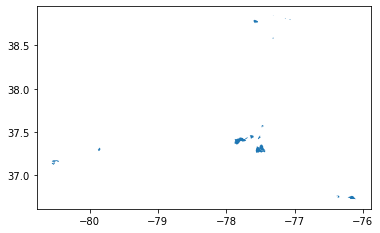

In [96]:
#important
shp[shp['unique_id_2'].isin(['041111',
 '041216',
 '041314',
 '041319',
 '041412',
 '059700',
 '121203',
 '153109',
 '153315',
 '161405',
 '510112',
 '510309',
 '550006',
 '550049',
 '750004',
 '760114',
 '760215'])].plot()

<AxesSubplot:>

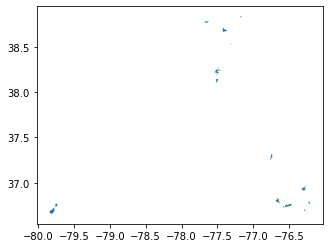

In [97]:
#important
final[final['unique_id_2'].isin(['059513-8',
 '089304-5',
 '089505-5',
 '095202-1',
 '095504-1',
 '153110-1',
 '153112-1',
 '153210-1',
 '153312-1',
 '153609-1',
 '177103-1',
 '177402-1',
 '177702-1',
 '177703-1',
 '177704-1',
 '550020-3',
 '550040',
 '550047',
 '650215-2',
 '710104-2',
 '800302-3',
 '800404-3',
 '800504-3',
 '800602-3'])].plot()

**It looks like the remaining geometries do not match up, so it is not a unique id problem, it is an actual missing area problem.**

In [98]:
set(df_with_absentee_reallocated.unique_id_2) - set(final.unique_id_2)
# see that unique_2 does not match like unique_1 but for plotting purposes it does not matter because those ids do overlap.

{'003407',
 '003507',
 '041111-4',
 '077401-9',
 '095104-2',
 '121203-9',
 '153106-1',
 '153109-1',
 '161405-6',
 '191702-9',
 '520004-9',
 '550006-4',
 '550049-4',
 '685003-10',
 '760114-4'}

## Join election results and shapefile

<AxesSubplot:>

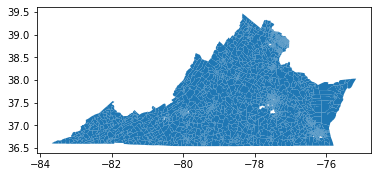

In [99]:
join = gpd.GeoDataFrame(pd.merge(df_with_absentee_reallocated, shp, on = 'unique_id_2', how = 'inner'), crs = proj)
join.plot()

In [100]:
join.shape

(2438, 44)

In [101]:
shp.shape

(2455, 19)

In [102]:
df_with_absentee_reallocated.unique_id_2.nunique()

2462

In [103]:
set(df_with_absentee_reallocated.unique_id_2) - set(shp.unique_id_2)

{'059513-8',
 '089304-5',
 '089505-5',
 '095202-1',
 '095504-1',
 '153110-1',
 '153112-1',
 '153210-1',
 '153312-1',
 '153609-1',
 '177103-1',
 '177402-1',
 '177702-1',
 '177703-1',
 '177704-1',
 '550020-3',
 '550040',
 '550047',
 '650215-2',
 '710104-2',
 '800302-3',
 '800404-3',
 '800504-3',
 '800602-3'}

# Validation

## Shapfile validation

In [104]:
join.head()

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP_x,countyfp_cd,...,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,unique_id_y,unique_id_1_y
0,1,101 - Bowling Green,725.0,357.0,0.0,1,0.0,Caroline County,033,033-1,...,None,None,None,Bowling Green,90,N,None,G5240,033101,033101
1,2,102 - Sparta,518.0,305.0,1.0,1,0.0,Caroline County,033,033-1,...,None,None,None,Sparta,90,N,None,G5240,033102,033102
2,3,201 - North Madison,428.0,506.0,0.0,1,0.0,Caroline County,033,033-1,...,None,None,None,North Madison,90,N,None,G5240,033201,033201
3,4,202 - South Madison,640.0,520.0,0.0,1,0.0,Caroline County,033,033-1,...,None,None,None,South Madison,90,N,None,G5240,033202,033202
4,5,301 - Port Royal,281.0,196.0,0.0,1,0.0,Caroline County,033,033-1,...,None,None,None,Port Royal,90,N,None,G5240,033301,033301


In [105]:
join.columns

Index(['index', 'Pct', 'G18HORREP', 'G18HORDEM', 'G18HORWRI', 'CON_DIST',
       'G18HORLIB', 'LOCALITY', 'COUNTYFP_x', 'countyfp_cd', 'G18HORREP_add',
       'G18HORREP_rem', 'G18HORREP_floor', 'G18HORDEM_add', 'G18HORDEM_rem',
       'G18HORDEM_floor', 'G18HORWRI_add', 'G18HORWRI_rem', 'G18HORWRI_floor',
       'G18HORLIB_add', 'G18HORLIB_rem', 'G18HORLIB_floor', 'vtdst',
       'unique_id_x', 'unique_id_1_x', 'unique_id_2', 'geometry', 'STATEFP',
       'COUNTYFP_y', 'VTDST', 'NAMELSAD', 'VTDI', 'LSAD', 'CHNG_TYPE',
       'ORIG_NAME', 'ORIG_CODE', 'RELATE', 'NAME', 'VINTAGE', 'FUNCSTAT',
       'JUSTIFY', 'MTFCC', 'unique_id_y', 'unique_id_1_y'],
      dtype='object')

In [106]:
set(final['unique_id_2']) - set(join['unique_id_2'])

{'003499',
 '003599',
 '041111',
 '059513-8',
 '059700',
 '077401',
 '089304-5',
 '089505-5',
 '095104',
 '095202-1',
 '095504-1',
 '121203',
 '153106',
 '153109',
 '153110-1',
 '153112-1',
 '153210-1',
 '153312-1',
 '153609-1',
 '161405',
 '177103-1',
 '177402-1',
 '177702-1',
 '177703-1',
 '177704-1',
 '191702',
 '520004',
 '550006',
 '550020-3',
 '550040',
 '550047',
 '550049',
 '650215-2',
 '685003',
 '710104-2',
 '760114',
 '800302-3',
 '800404-3',
 '800504-3',
 '800602-3'}

In [107]:
shp_final_merge = pd.merge(join, final, on = 'unique_id_2', how = 'outer', suffixes = ['_x', '_y'],indicator=True)

In [108]:
both = shp_final_merge[shp_final_merge["_merge"]=="both"]
source_geoms = gpd.GeoDataFrame(both,geometry="geometry_x",crs=final.crs)
vest_geoms = gpd.GeoDataFrame(both,geometry="geometry_y",crs=final.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     1769
False     654
dtype: int64


1) For 301 - South difference in area is 2.47207267955882
2) For 401 - Central difference in area is 2.47207267955882
3) For 201 - Beaverdam difference in area is 1.208716033666942
4) For 202 - Blunts difference in area is 1.2087160336624603
5) For 213 - Phillips difference in area is 1.3935733795237344
6) For 11 - Geneva Park difference in area is 1.1457984206821203
7) For 319 - Saunders difference in area is 2.0626894059507426
8) For 1 - Great Bridge difference in area is 2.8494320033778533
9) For 2 - Bethel difference in area is 2.538696824575388
10) For 20 - E W Chittum difference in area is 1.7854534822636545
11) For 45 - Sunray II difference in area is 2.158233200662478
12) For 201 - Gates difference in area is 7.916663970014204
13) For 501 - Hunterdale difference in area is 2.6810275008244133
14) For 401 - Airport difference in area is 2.106828692572283
15) For 501 - Reedy Creek difference in area is 1.2889583355036323
16) For 701 - Meherrin Fire Department difference in area is

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


22) For 501 - Number Five difference in area is 1.1100188908965825
23) For 208 - Meadowbrook difference in area is 11.69378938112867
24) For 307 - Cosby difference in area is 2.248562299915324
25) For 502 - Rixeyville difference in area is 1.0661449758085542
26) For 603 - South Ridge difference in area is 2.697575844323418
27) For 702 - Brandy Station difference in area is 2.6986443230844803
28) For 301 - Patrick Henry No 1 difference in area is 1.4164808261417894
29) For 202 - Graceland difference in area is 1.161132075930226
30) For 101 - Partlow difference in area is 1.5286514996213678
31) For 301 - Baywood difference in area is 3.905175042577253
32) For 201 - Fieldale difference in area is 1.1759523992196976
33) For 202 - South Pulaski difference in area is 1.1428642396626618
34) For 851 - Willow Springs difference in area is 2.1695885815974254


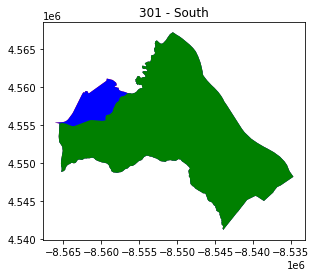

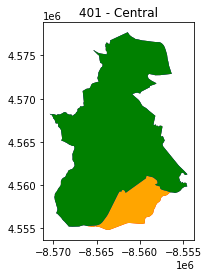

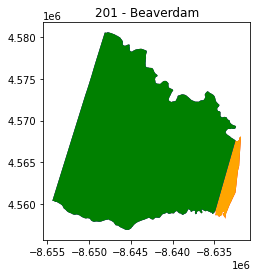

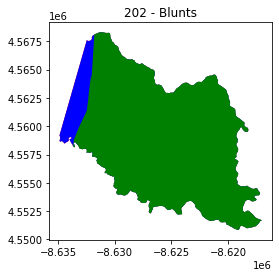

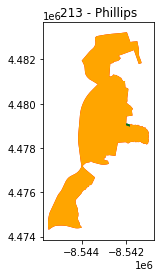

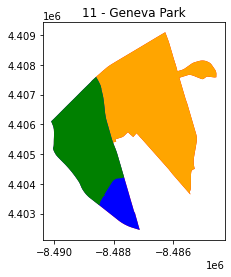

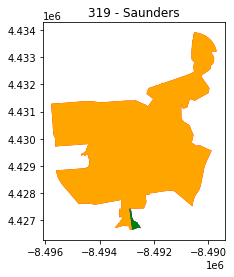

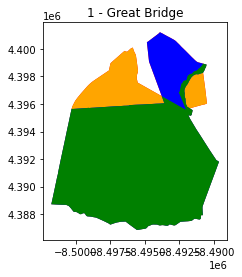

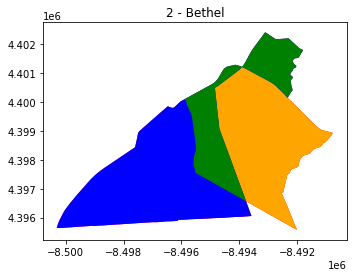

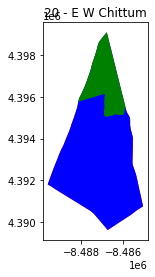

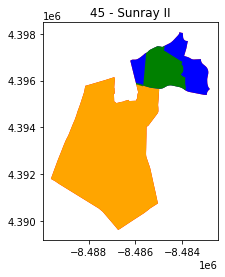

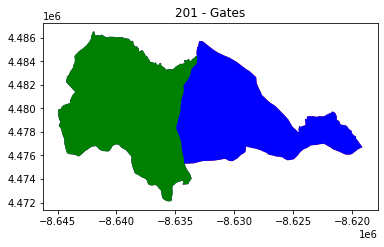

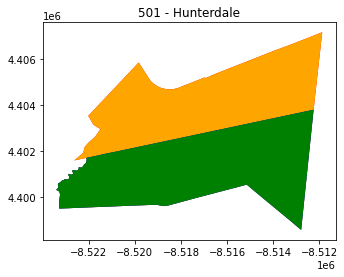

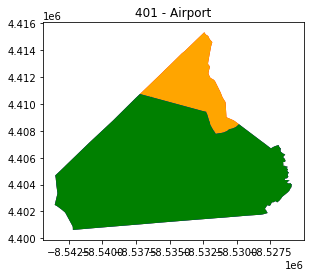

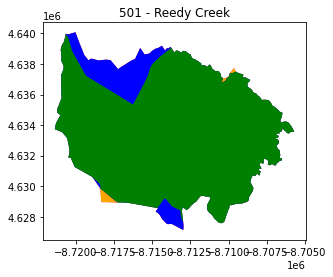

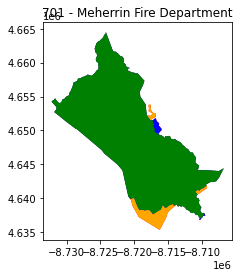

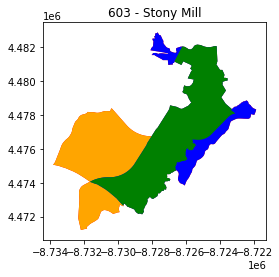

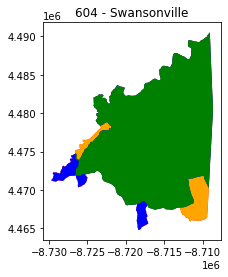

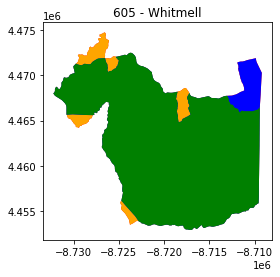

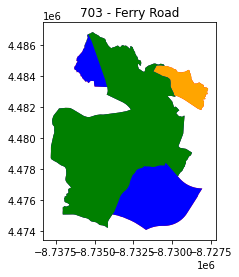

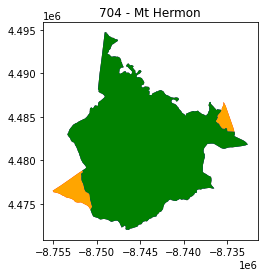

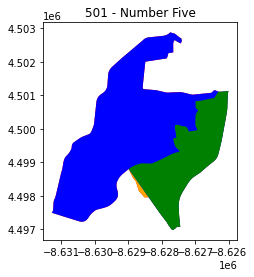

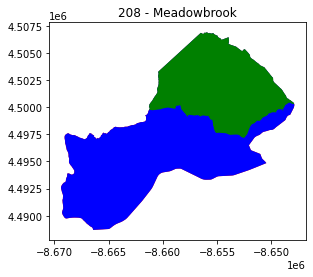

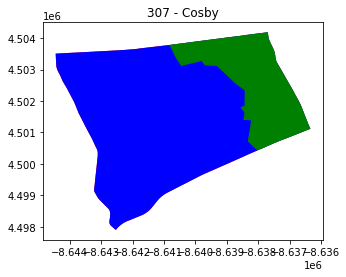

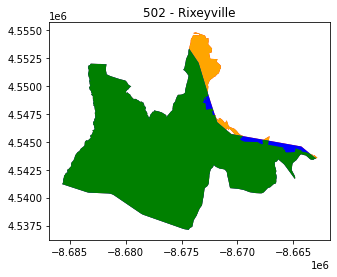

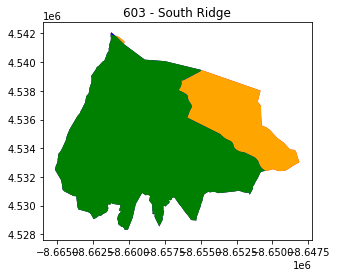

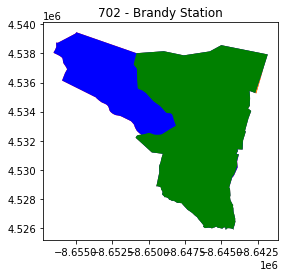

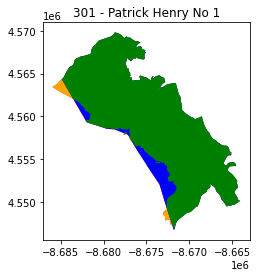

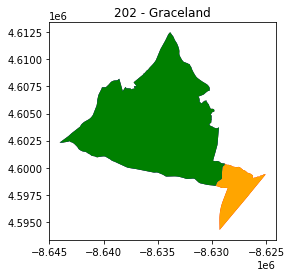

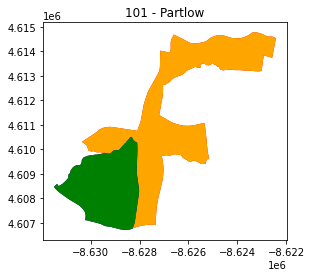

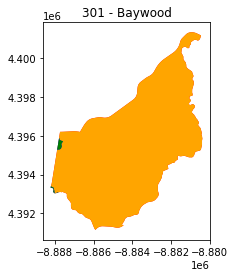

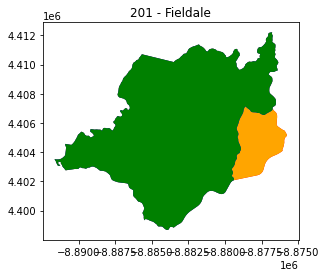

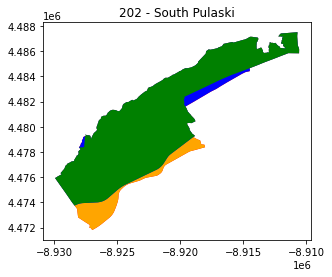

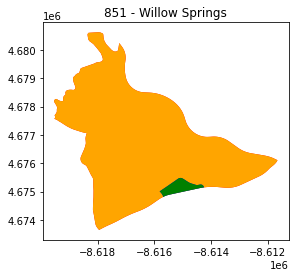

In [109]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > 1):
        count += 1
        name = source_geoms.at[i,"Pct"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [110]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2423, 1)
1787 precincts w/ a difference of 0 km^2
526 precincts w/ a difference between 0 and .1 km^2
60 precincts w/ a difference between .1 and .5 km^2
16 precincts w/ a difference between .5 and 1 km^2
15 precincts w/ a difference between 1 and 2 km^2
17 precincts w/ a difference between 2 and 5 km^2
2 precincts w/ a difference greater than 5 km^2


## Merge and check precinct level election results

In [111]:
print(set(final.unique_id_1) - set(df_with_absentee_reallocated.unique_id_1))
final[final.unique_id_1 == '059700-11'] #dont recreate in election result df because 0 votes

{'059700-11'}


,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1,unique_id_2
600,059,Fairfax County,000700,Fairfax Court,11,0,0,0,0,"POLYGON Z ((-77.31648 38.84615 0.00000, -77.31...",059700,059700-11,059700


In [112]:
set(df_with_absentee_reallocated.unique_id_1) - set(final.unique_id_1)

set()

In [113]:
final.columns

Index(['COUNTYFP', 'LOCALITY', 'VTDST', 'PRECINCT', 'CON_DIST', 'G18HORDEM',
       'G18HORREP', 'G18HORLIB', 'G18HORWRI', 'geometry', 'unique_id',
       'unique_id_1', 'unique_id_2'],
      dtype='object')

In [114]:
final_df_merge = pd.merge(df_with_absentee_reallocated, final, on = 'unique_id_1')

In [119]:
print(df_with_absentee_reallocated["unique_id_1"].value_counts())
print(final["unique_id_1"].value_counts())
print(df_with_absentee_reallocated.shape)
print(final.shape)
print(final[~(final["unique_id_1"].isin(list(df_with_absentee_reallocated["unique_id_1"])))])

085303-1     1
810077-2     1
085203-1     1
105502-9     1
043201-10    1
            ..
810062-2     1
153214-1     1
191703-9     1
041403-7     1
570001-4     1
Name: unique_id_1, Length: 2462, dtype: int64
085303-1    1
550025-3    1
590016-5    1
011302-5    1
041417-7    1
           ..
101202-1    1
550041-4    1
800301-4    1
133301-1    1
059408-8    1
Name: unique_id_1, Length: 2463, dtype: int64
(2462, 26)
(2463, 13)
    COUNTYFP        LOCALITY   VTDST       PRECINCT CON_DIST  G18HORDEM  \
600      059  Fairfax County  000700  Fairfax Court       11          0   

     G18HORREP  G18HORLIB  G18HORWRI  \
600          0          0          0   

                                              geometry unique_id unique_id_1  \
600  POLYGON Z ((-77.31648 38.84615 0.00000, -77.31...    059700   059700-11   

    unique_id_2  
600      059700  


In [115]:
col_list = ['G18HORDEM', 'G18HORREP', 'G18HORLIB', 'G18HORWRI']

In [116]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["Pct"]), "(V)","{:.>5}".format(int(df.iloc[j][right_Data]))," (S){:.>5}".format(int(df.iloc[j][left_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["Pct"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["Pct"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [117]:
validater_row(final_df_merge, col_list)

G18HORREP .....................................................101 - Bowling Green (V) ..725  (S)..726 (D):    1
G18HORDEM ............................................................102 - Sparta (V) ..305  (S)..306 (D):    1
G18HORREP ............................................................102 - Sparta (V) ..518  (S)..517 (D):   -1
G18HORREP .....................................................201 - North Madison (V) ..428  (S)..427 (D):   -1
G18HORREP .....................................................202 - South Madison (V) ..640  (S)..641 (D):    1
G18HORREP ..........................................................302 - Woodford (V) ..666  (S)..667 (D):    1
G18HORDEM .....................................................402 - Carmel Church (V) ..318  (S)..319 (D):    1
G18HORREP .....................................................402 - Carmel Church (V) ..198  (S)..197 (D):   -1
G18HORDEM ....................................................501 - West Mattaponi (V) ..665  (S

G18HORREP ...........................................................301 - Watkins (V) ..541  (S)..540 (D):   -1
G18HORDEM ................................................................201 - 2a (V) ..415  (S)..414 (D):   -1
G18HORDEM ................................................................401 - 4a (V) ..483  (S)..484 (D):    1
G18HORDEM .......................................................101 - Brentsville (V) ..532  (S)..531 (D):   -1
G18HORREP ..........................................................103 - Glenkirk (V) ..934  (S)..935 (D):    1
G18HORDEM ..........................................................106 - Westgate (V) ..961  (S)..962 (D):    1
G18HORDEM ...........................................................108 - Victory (V) .1613  (S).1612 (D):   -1
G18HORREP ...........................................................108 - Victory (V) .1020  (S).1021 (D):    1
G18HORDEM ....................................................110 - Buckland Mills (V) ..261  (S

G18HORDEM ............................................................4 - Linkhorn (V) ..799  (S)..798 (D):   -1
G18HORREP ............................................................4 - Linkhorn (V) .1184  (S).1183 (D):   -1
G18HORDEM .............................................................5 - Seatack (V) .1057  (S).1058 (D):    1
G18HORDEM .............................................................6 - Alanton (V) ..879  (S)..880 (D):    1
G18HORREP .............................................................6 - Alanton (V) .1268  (S).1267 (D):   -1
G18HORDEM ...........................................................9 - Trantwood (V) ..746  (S)..745 (D):   -1
G18HORREP .........................................................10 - Great Neck (V) .1494  (S).1495 (D):    1
G18HORREP .........................................................11 - Cape Henry (V) .1223  (S).1222 (D):   -1
G18HORDEM .............................................................14 - Malibu (V) ..932  (S

G18HORDEM ............................................................210 - Machen (V) .2142  (S).2143 (D):    1
G18HORDEM .............................................................215 - Tyler (V) ..379  (S)..380 (D):    1
G18HORWRI ........................................................101 - Smithfield (V) ..337  (S)..336 (D):   -1
G18HORWRI ..........................................................201 - Bartlett (V) ..340  (S)..341 (D):    1
G18HORDEM ...........................................................109 - Windsor (V) ..859  (S)..860 (D):    1
G18HORDEM .........................................................204 - Wellesley (V) ..901  (S)..902 (D):    1
G18HORDEM ........................................................205 - Deep Creek (V) .1170  (S).1171 (D):    1
G18HORDEM .........................................................208 - Hidenwood (V) ..692  (S)..691 (D):   -1
G18HORDEM ............................................................209 - Hilton (V) .1026  (S

G18HORDEM ............................................................201 - Rohoic (V) ..379  (S)..378 (D):   -1
G18HORDEM ...........................................................502 - Chesdin (V) .1104  (S).1105 (D):    1
G18HORDEM .........................................................208 - Fairfield (V) .1497  (S).1496 (D):   -1
G18HORDEM ..........................................................209 - Glen Lea (V) .1030  (S).1031 (D):    1
G18HORDEM .........................................................220 - Ratcliffe (V) .2103  (S).2102 (D):   -1
G18HORDEM .....................................................224 - Essex Village (V) ..395  (S)..396 (D):    1
G18HORDEM ......................................................503 - Chickahominy (V) ..759  (S)..758 (D):   -1
G18HORREP .............................................................505 - Dorey (V) ..794  (S)..795 (D):    1
G18HORREP .............................................................506 - Eanes (V) ..332  (S

G18HORREP .......................................................16 - Ward Sixteen (V) ..747  (S)..746 (D):   -1
G18HORDEM .....................................................17 - Ward Seventeen (V) ..365  (S)..364 (D):   -1
G18HORREP .....................................................17 - Ward Seventeen (V) ..850  (S)..851 (D):    1
G18HORREP ........................................................101 - Kettle Run (V) ..609  (S)..608 (D):   -1
G18HORDEM ..........................................................103 - Casanova (V) ..384  (S)..383 (D):   -1
G18HORREP ..........................................................103 - Casanova (V) ..533  (S)..532 (D):   -1
G18HORREP ............................................................202 - Airlie (V) .1055  (S).1056 (D):    1
G18HORDEM .............................................................402 - Leeds (V) ..818  (S)..819 (D):    1
G18HORREP .........................................................503 - Broad Run (V) ..949  (S

G18HORDEM .......................................................405 - Cedar Green (V) ..382  (S)..383 (D):    1
G18HORREP .......................................................405 - Cedar Green (V) ..727  (S)..726 (D):   -1
G18HORDEM ........................................................501 - Greenville (V) ..337  (S)..338 (D):    1
G18HORDEM ........................................................504 - White Hill (V) ..351  (S)..352 (D):    1
G18HORREP .........................................................603 - Lyndhurst (V) .1082  (S).1081 (D):   -1
G18HORREP ......................................................802 - Fishersville (V) .1386  (S).1387 (D):    1
G18HORDEM ................................................301 - New London Academy (V) ..344  (S)..343 (D):   -1
G18HORDEM ..........................................403 - Knights Of Columbus Bldg (V) ..595  (S)..596 (D):    1
G18HORREP ..........................................403 - Knights Of Columbus Bldg (V) .1488  (S

G18HORDEM .....................................................503 - Mcgaheysville (V) ..431  (S)..432 (D):    1
G18HORREP .....................................................503 - Mcgaheysville (V) .1063  (S).1064 (D):    1
G18HORDEM .........................................................505 - Stony Run (V) ..586  (S)..587 (D):    1
G18HORREP .........................................................505 - Stony Run (V) ..765  (S)..764 (D):   -1
G18HORREP ....................................................101 - Orkney Springs (V) ..518  (S)..517 (D):   -1
G18HORDEM ........................................................202 - Mt Jackson (V) ..359  (S)..358 (D):   -1
G18HORREP ........................................................202 - Mt Jackson (V) ..774  (S)..775 (D):    1
G18HORREP .......................................................304 - Fort Valley (V) ..512  (S)..511 (D):   -1
G18HORDEM .........................................................401 - Woodstock (V) .1013  (S

G18HORDEM .........................................................105 - Greendale (V) .1406  (S).1405 (D):   -1
G18HORDEM .........................................................106 - Hermitage (V) .1252  (S).1253 (D):    1
G18HORDEM .....................................................108 - Hungary Creek (V) .1573  (S).1574 (D):    1
G18HORREP ............................................................109 - Hunton (V) ..397  (S)..398 (D):    1
G18HORLIB ..........................................................111 - Lakeside (V) ...48  (S)...49 (D):    1
G18HORREP ....................................................114 - Monument Hills (V) ..379  (S)..380 (D):    1
G18HORREP ...........................................................203 - Belmont (V) ..424  (S)..425 (D):    1
G18HORDEM .........................................................204 - Brookland (V) ..307  (S)..308 (D):    1
G18HORREP ......................................................207 - Chamberlayne (V) ..424  (S

G18HORWRI ...........................................................22 - Abingdon (V) ...12  (S)...13 (D):    1
G18HORDEM ...........................................................23 - Westover (V) .1643  (S).1644 (D):    1
G18HORDEM ...........................................................24 - Woodlawn (V) .2181  (S).2180 (D):   -1
G18HORREP ...........................................................24 - Woodlawn (V) ..483  (S)..484 (D):    1
G18HORREP .....................................................29 - Dominion Hills (V) ..432  (S)..433 (D):    1
G18HORREP ...........................................................34 - Yorktown (V) ..453  (S)..454 (D):    1
G18HORREP ............................................................35 - Madison (V) ..784  (S)..783 (D):   -1
G18HORDEM .........................................................37 - Nottingham (V) .1552  (S).1553 (D):    1
G18HORREP .........................................................37 - Nottingham (V) ..461  (S

G18HORREP ......................................................301 - Hillsville C (V) ..967  (S)..968 (D):    1
G18HORREP ...........................................................401 - Oakland (V) ..726  (S)..727 (D):    1
G18HORREP ........................................................503 - Woodlawn E (V) ..344  (S)..343 (D):   -1
G18HORREP ............................................................504 - Laurel (V) ..401  (S)..400 (D):   -1
G18HORDEM ......................................................401 - Haysi-colley (V) ..384  (S)..385 (D):    1
G18HORDEM ...................................................502 - North Clintwood (V) ..264  (S)..263 (D):   -1
G18HORREP ......................................................101 - Locust Grove (V) ..857  (S)..856 (D):   -1
G18HORREP ......................................................201 - Little River (V) ..905  (S)..906 (D):    1
G18HORREP ........................................................401 - Burks Fork (V) ..830  (S

G18HORDEM ........................................................101 - Appalachia (V) ..258  (S)..257 (D):   -1
G18HORDEM ........................................................104 - West Pound (V) ..306  (S)..305 (D):   -1
G18HORDEM ..............................................................202 - Wise (V) ..542  (S)..543 (D):    1
G18HORDEM .....................................................301 - Big Stone Gap (V) ..415  (S)..416 (D):    1
G18HORDEM ...................................................203 - West Wytheville (V) ..632  (S)..633 (D):    1
G18HORDEM ...................................................303 - East Wytheville (V) ..675  (S)..676 (D):    1
G18HORDEM ...........................................................502 - Sheffey (V) ..192  (S)..191 (D):   -1
G18HORDEM ............................................................601 - Huddle (V) ...74  (S)...73 (D):   -1
G18HORDEM ...........................................................101 - Russell (V) ..517  (S

G18HORREP .......................................................508 - Balls Bluff (V) ..828  (S)..829 (D):    1
G18HORDEM ..........................................................615 - Hillside (V) .1114  (S).1113 (D):   -1
G18HORDEM .......................................................616 - Eagle Ridge (V) .1304  (S).1305 (D):    1
G18HORREP .........................................................617 - Oak Grove (V) ..188  (S)..187 (D):   -1
G18HORREP ..........................................................619 - Ridgetop (V) ..207  (S)..206 (D):   -1
G18HORREP ....................................................620 - Russell Branch (V) ..913  (S)..914 (D):    1
G18HORREP ............................................................623 - Weller (V) .1029  (S).1030 (D):    1
G18HORREP .......................................................626 - Ashby Ponds (V) ..542  (S)..541 (D):   -1
G18HORDEM ..........................................................627 - Ashbrook (V) ..545  (S

G18HORREP ........................................................508 - Masonville (V) ..553  (S)..552 (D):   -1
G18HORDEM .........................................................511 - Ravenwood (V) .1266  (S).1265 (D):   -1
G18HORREP .........................................................511 - Ravenwood (V) ..463  (S)..462 (D):   -1
G18HORDEM ..........................................................518 - Columbia (V) .1255  (S).1254 (D):   -1
G18HORREP ..........................................................518 - Columbia (V) ..493  (S)..492 (D):   -1
G18HORDEM ...........................................................522 - Camelot (V) ..704  (S)..705 (D):    1
G18HORREP ..........................................................528 - Ridgelea (V) ..302  (S)..301 (D):   -1
G18HORREP .........................................................530 - Holmes #2 (V) ..211  (S)..210 (D):   -1
G18HORLIB .........................................................618 - Newington (V) ...76  (S